# Classification and Clustering experiments

# Dataset
**SMS Spam Collection Data Set**
[https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection]

**Abstract:**The SMS Spam Collection is a public set of SMS labeled messages that have been collected for mobile phone spam research.

| Data Set Characteristics  | Associated Tasks | Number of Instances | Number of Attributes |
| ------------- | ------------- | ------------- | ------------- |
| Text          | Classification, Clustering | 5574  | N/A |

# References
- http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
- https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
- https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
- https://github.com/jmportilla/Udemy---Machine-Learning/blob/master/NLP%20(Natural%20Language%20Processing).ipynb
- http://www.ritchieng.com/machine-learning-evaluate-classification-model/
- https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/#parameter-tuning-with-cross-validation
- http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

## Environment Setup

In [1]:
import numpy as np
import pandas as pd
import os

# Make notebook's output stable across runs
np.random.seed(42)

# Set graph parameters
%matplotlib inline
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
# Set the spam dataset path
MESSAGES_PATH = 'datasets\sms'

# Function to load the spam dataset
def load_messages_data(messages_path=MESSAGES_PATH):
    file_path = os.path.join(messages_path, 'SMSSpamCollection')
    return pd.read_csv(file_path, sep='\t', names=['label', 'message'])

In [3]:
messages = load_messages_data()
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


## Sparse to dense transformer
- Reference - http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
- Convert a sparse matrix to a dense numpy array

In [6]:
from sklearn.base import TransformerMixin

class DenseTransformer(TransformerMixin):
    
    def transform(self, X, y=None):
        return X.todense()
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

## Experiment 1. 
Use sklearn.model_selection.train_test_split to split your data into training and test sets.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

X_train, X_test, y_train, y_test = train_test_split(messages['message'], messages['label'])
y_train = label_binarize(y_train, classes=['spam', 'ham'])
y_test = label_binarize(y_test, classes=['spam', 'ham'])
print(y_test.shape)

(1393, 1)


In [8]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

4179 1393 4179 1393


## Experiment 2.
Fit an sklearn.naive_bayes.GaussianNB classifier to your dataset.

In [9]:
# Preprocess the data
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB

# Pipeline features - vectorizer -> transformer -> classifier
# CountVectorizer - Text Preprocessing, tokenizing, and filtering of stopwords - dictionary of feature indices
# TfidfTransformer - Term frequencies, and downscaling weights for words - tf and tf-idf
# DenseTransformer - Transform sparse matrix to dense
# GaussianNB - Naive Bayes Classifier

gnb_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB()),
])

In [10]:
y_train = y_train.reshape(y_train.shape[0],)
gnb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...dense', <__main__.DenseTransformer object at 0x000002E8776FEB00>), ('clf', GaussianNB(priors=None))])

## Experiment 3.
Use your Naive Bayes classifier to predict the labels for your dataset, and evaluate its performance

In [11]:
y_gnb_pred = gnb_pipeline.predict(X_test)

In [12]:
from sklearn.metrics import roc_curve, classification_report

print(classification_report(y_gnb_pred, y_test))
print("Accuracy:", np.mean(y_gnb_pred == y_test))

             precision    recall  f1-score   support

          0       0.91      0.59      0.72       288
          1       0.90      0.99      0.94      1105

avg / total       0.90      0.90      0.90      1393

Accuracy: 0.714939171295


In [13]:
# Binarize the output
from sklearn.metrics import roc_curve

y_gnb_pred_prob = gnb_pipeline.predict_proba(X_test)[:, 1]
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, y_gnb_pred_prob)


In [14]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

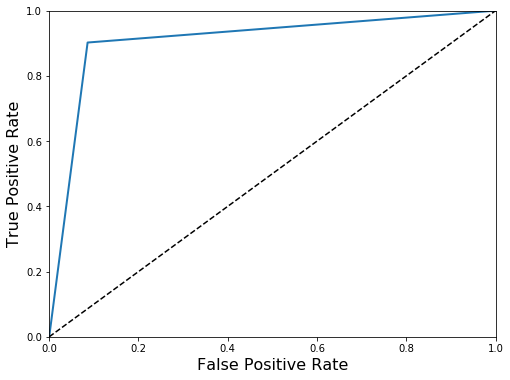

In [15]:
plt.figure(figsize=(8, 6))
plot_roc_curve(gnb_fpr, gnb_tpr)
plt.show()

## Experiment 4.
Fit an sklearn.neighbors.KNeighborsClassifier to your dataset,
evaluate its sklearn.metrics.zero_one_loss over the range n_neighbors = 5 to n_neighbors = √N

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Pipeline features - vectorizer -> transformer -> classifier
# CountVectorizer - Text Preprocessing, tokenizing, and filtering of stopwords - dictionary of feature indices
# TfidfTransformer - Term frequencies, and downscaling weights for words - tf and tf-idf
# DenseTransformer - Transform sparse matrix to dense
# KNeighborsClassifier - Classifier implementing the k-nearest neighbors vote

knn_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('to_dense', DenseTransformer()),
    ('clf', KNeighborsClassifier()),
])

In [17]:
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [18]:
y_knn_pred = knn_pipeline.predict(X_test)

In [19]:
print(classification_report(y_knn_pred, y_test))
print("Accuracy:", np.mean(y_knn_pred == y_test))

             precision    recall  f1-score   support

          0       0.38      1.00      0.55        71
          1       1.00      0.91      0.95      1322

avg / total       0.97      0.92      0.93      1393

Accuracy: 0.829117384688


### Evaluate its sklearn.metrics.zero_one_loss over the range n_neighbors = 5 to n_neighbors = √N

In [20]:
# Pipeline features - vectorizer -> transformer
# CountVectorizer - Text Preprocessing, tokenizing, and filtering of stopwords - dictionary of feature indices
# TfidfTransformer - Term frequencies, and downscaling weights for words - tf and tf-idf
# DenseTransformer - Transform sparse matrix to dense

transformer_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('to_dense', DenseTransformer()),
])

In [21]:
X_train_transformed = transformer_pipeline.fit_transform(X_train)

In [22]:
# Best k zero one loss
from math import sqrt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import zero_one_loss

neighbors = int(sqrt(len(X_train)))

knn_err = np.zeros((neighbors,))

#knn = KNeighborsClassifier(n_neighbors=k)
y_train_r = y_train.reshape(y_train.shape[0],)
#y_pred_all = cross_val_predict(knn, X_train_transformed, y_train_r)
#knn_err[i] = zero_one_loss(y_pred_all, y_train_r)
for i,k in enumerate(range(5, neighbors)):
    knn = KNeighborsClassifier(n_neighbors=k)
    y_pred_all = cross_val_predict(knn, X_train_transformed, y_train_r)
    knn_err[i] = zero_one_loss(y_pred_all, y_train_r)
    
    

In [23]:
knn_err.shape

(64,)

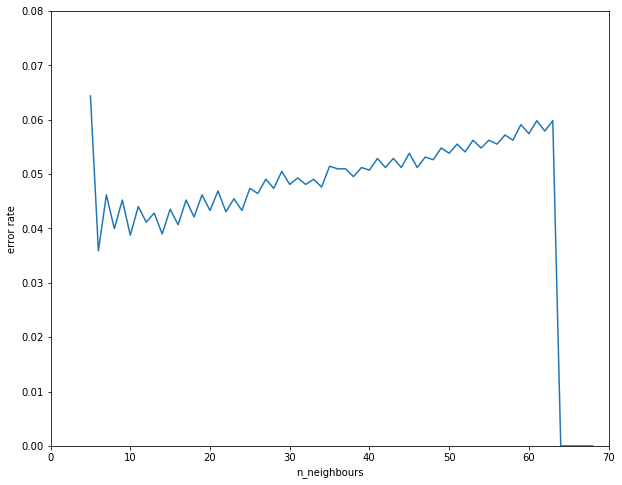

In [24]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(np.arange(5, neighbors+5), knn_err, label="KNN Train Error")
ax.set_ylim((0.0, 0.08))
ax.set_xlim((0, 70))
ax.set_xlabel('n_neighbours')
ax.set_ylabel('error rate')
plt.show()

In [25]:
cv_scores = []
from sklearn.model_selection import cross_val_score
for k in range(5, neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_transformed, y_train_r, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [26]:
neighbors_list = list(range(5,neighbors))
MSE = [1 - x for x in cv_scores]
print(min(MSE))
print(MSE.index(min(MSE)))
neighbors_list[MSE.index(min(MSE))]
optimal_k = neighbors_list[MSE.index(min(MSE))]
print(optimal_k)

0.039727296853
7
12


In [27]:
best_knn_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('to_dense', DenseTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=6)),
])

In [28]:
best_knn_pipeline.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...owski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'))])

In [29]:
y_pred_best_knn = best_knn_pipeline.predict(X_test)

In [30]:
print(classification_report(y_pred_best_knn, y_test))
print("Accuracy:", np.mean(y_pred_best_knn == y_test))

             precision    recall  f1-score   support

          0       0.75      0.99      0.86       141
          1       1.00      0.96      0.98      1252

avg / total       0.97      0.97      0.97      1393

Accuracy: 0.792285702948


## Experiment 5.
Compare the performance of the Naive Bayes classifier in experiment (3) to the KNN classifier with the best choice for K from experiment (4)

In [31]:
y_knn_pred_prob = best_knn_pipeline.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, y_knn_pred_prob)

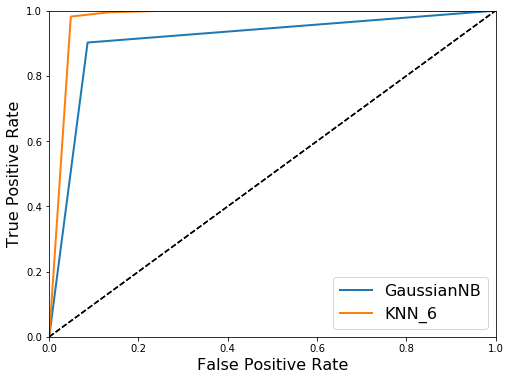

In [32]:
plt.figure(figsize=(8, 6))
plot_roc_curve(gnb_fpr, gnb_tpr, "GaussianNB")
plot_roc_curve(knn_fpr, knn_tpr, "KNN_6")
plt.legend(loc="lower right", fontsize=16)
plt.show()

## Experiment 6.
Fit an sklearn.svm.SVC to your dataset. 
Compare the sklearn.metrics.zero_one_loss of kernel='linear' and kernel='poly' with degree = 3 and degree = 5

In [33]:
from sklearn.svm import SVC

# Pipeline features - vectorizer -> transformer -> classifier
# CountVectorizer - Text Preprocessing, tokenizing, and filtering of stopwords - dictionary of feature indices
# TfidfTransformer - Term frequencies, and downscaling weights for words - tf and tf-idf
# DenseTransformer - Transform sparse matrix to dense
# SVC - C-Support Vector Classification

svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('to_dense', DenseTransformer()),
    ('clf', SVC(kernel='linear')),
])

In [34]:
svc_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [35]:
y_svc_pred = svc_pipeline.predict(X_test)

In [36]:
print(classification_report(y_svc_pred, y_test))
print("Accuracy:", np.mean(y_svc_pred == y_test))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       174
          1       1.00      0.99      1.00      1219

avg / total       0.99      0.99      0.99      1393

Accuracy: 0.774922195842


In [37]:
svc_err = np.zeros((3))
svc_err

array([ 0.,  0.,  0.])

In [38]:
for i, params in enumerate([['linear', 3], ['poly', 3], ['poly', 5]]):
    svc = SVC(degree=params[1], kernel=params[0])
    y_pred_all = cross_val_predict(svc, X_train_transformed, y_train_r)
    svc_err[i] = zero_one_loss(y_pred_all, y_train_r)

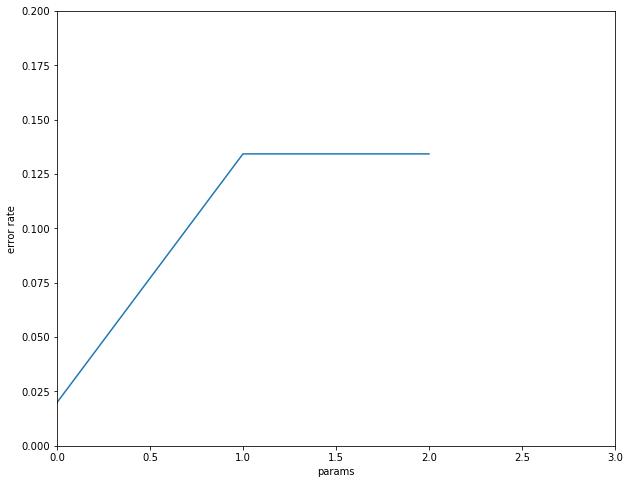

In [39]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(np.arange(3), svc_err, label="SVC Train Error")
ax.set_ylim((0.0, 0.2))
ax.set_xlim((0, 3))
ax.set_xlabel('params')
ax.set_ylabel('error rate')
plt.show()

## Experiment 7.
Compare the performance of the best SVM from experiment (6) with the performance in experiments (3) and (5). Which classification algorithm performed best for your dataset?

In [40]:
y_svc_pred_prob = svc_pipeline.decision_function(X_test)
svc_fpr, svc_tpr, _ = roc_curve(y_test, y_svc_pred_prob)

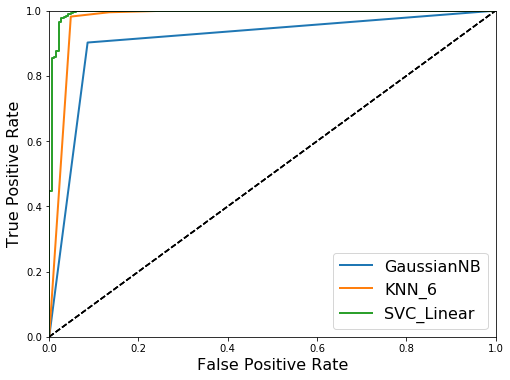

In [41]:
plt.figure(figsize=(8, 6))
plot_roc_curve(gnb_fpr, gnb_tpr, "GaussianNB")
plot_roc_curve(knn_fpr, knn_tpr, "KNN_6")
plot_roc_curve(svc_fpr, svc_tpr, "SVC_Linear")
plt.legend(loc="lower right", fontsize=16)
plt.show()

## Experiment 8.
Remove the labels from your dataset and run sklearn.cluster.KMeans on the features, with n_clusters set to the number of classes in your dataset. How do the labels_ found by the clustering algorithm compare to the original labels?

In [42]:
from sklearn.cluster import KMeans

# Pipeline features - vectorizer -> transformer -> classifier
# CountVectorizer - Text Preprocessing, tokenizing, and filtering of stopwords - dictionary of feature indices
# TfidfTransformer - Term frequencies, and downscaling weights for words - tf and tf-idf
# DenseTransformer - Transform sparse matrix to dense
# KMeans - K-Means clustering

kmeans_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('to_dense', DenseTransformer()),
    ('clf', KMeans(n_clusters=2)),
])

In [43]:
kmeans_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [44]:
y_kmeans_pred = kmeans_pipeline.predict(X_test)

In [45]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
print(y_kmeans_pred.shape)
y_test_t = y_test.reshape(y_test.shape[0],)
print(y_test_t.shape)
print(y_test.reshape(y_test.shape[0],).shape)
print("Adjusted Rand index:", adjusted_rand_score(y_test_t, y_kmeans_pred))

(1393,)
(1393,)
(1393,)
Adjusted Rand index: -0.0452090139922


In [46]:
y_kmeans_pred

array([0, 0, 0, ..., 0, 0, 1])

In [47]:
y_test_t

array([1, 1, 1, ..., 1, 1, 1])

In [48]:
y_train_reshaped = y_train.reshape(y_train.shape[0],)
print("Adjusted Rand index:", adjusted_rand_score(y_train_reshaped, kmeans_pipeline.steps[2][1].labels_))
kmeans_pipeline.steps[2][1].labels_

Adjusted Rand index: -0.0662308523836


array([0, 1, 1, ..., 0, 0, 0])

In [49]:
y_train_reshaped

array([0, 1, 1, ..., 1, 1, 1])

In [50]:
km_fpr, km_tpr, _ = roc_curve(y_train_reshaped, kmeans_pipeline.steps[2][1].labels_)

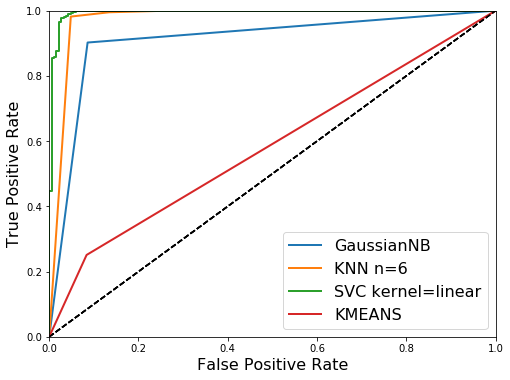

In [51]:
plt.figure(figsize=(8, 6))
plot_roc_curve(gnb_fpr, gnb_tpr, "GaussianNB")
plot_roc_curve(knn_fpr, knn_tpr, "KNN n=6")
plot_roc_curve(svc_fpr, svc_tpr, "SVC kernel=linear")
plot_roc_curve(km_fpr, km_tpr, "KMEANS")
plt.legend(loc="lower right", fontsize=16)
plt.show()